Using device: cuda
Loaded 1228 valid image-mask pairs
Epoch [1/25]
  Train Loss: 0.3207, Train Acc: 97.63%
  Val Loss: 0.2629, Val Acc: 98.59%
--------------------------------------------------
Epoch [2/25]
  Train Loss: 0.2289, Train Acc: 98.62%
  Val Loss: 0.2086, Val Acc: 98.66%
--------------------------------------------------
Epoch [3/25]
  Train Loss: 0.1850, Train Acc: 98.66%
  Val Loss: 0.1649, Val Acc: 98.66%
--------------------------------------------------
Epoch [4/25]
  Train Loss: 0.1525, Train Acc: 98.79%
  Val Loss: 0.1394, Val Acc: 98.92%
--------------------------------------------------
Epoch [5/25]
  Train Loss: 0.1251, Train Acc: 98.97%
  Val Loss: 0.1153, Val Acc: 98.91%
--------------------------------------------------
Epoch [6/25]
  Train Loss: 0.1038, Train Acc: 99.14%
  Val Loss: 0.0959, Val Acc: 99.18%
--------------------------------------------------
Epoch [7/25]
  Train Loss: 0.0844, Train Acc: 99.32%
  Val Loss: 0.0762, Val Acc: 99.32%
-----------------

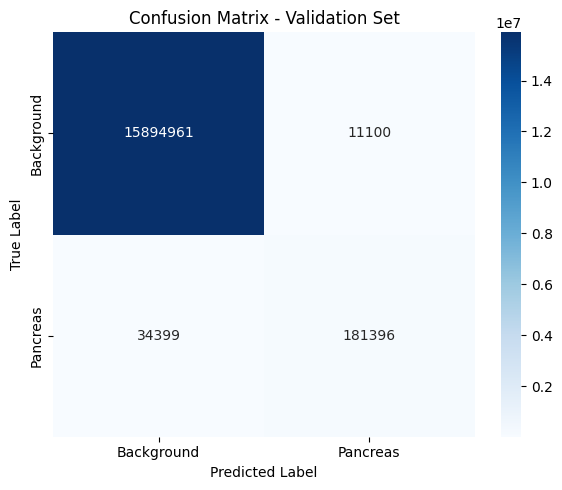

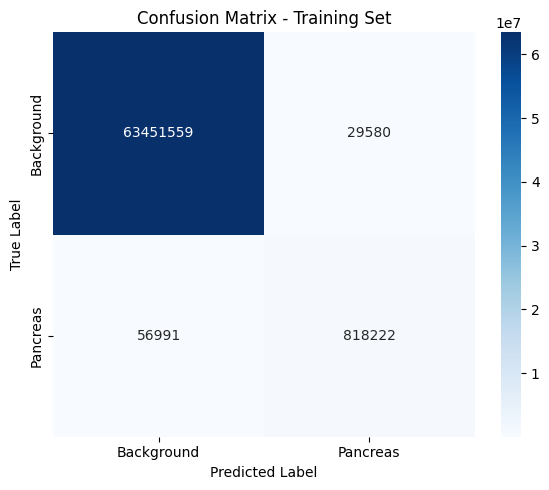


DETAILED CLASSIFICATION REPORT (Validation Set)
              precision    recall  f1-score   support

  Background     0.9978    0.9993    0.9986  15906061
    Pancreas     0.9423    0.8406    0.8886    215795

    accuracy                         0.9972  16121856
   macro avg     0.9701    0.9199    0.9436  16121856
weighted avg     0.9971    0.9972    0.9971  16121856


IoU Statistics (Validation Set):
  Mean IoU: 0.7960
  Std IoU:  0.1341
  Min IoU:  0.1424
  Max IoU:  0.9468


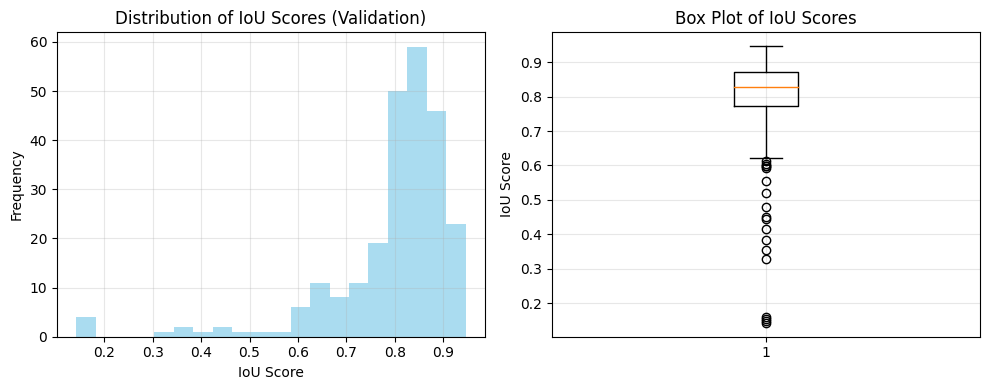


All metrics calculated and saved successfully!
Files created:
- confusion_matrix_validation_set.png
- confusion_matrix_training_set.png
- iou_distribution.png
- segmentation_metrics.txt
Model saved!
Model saved!


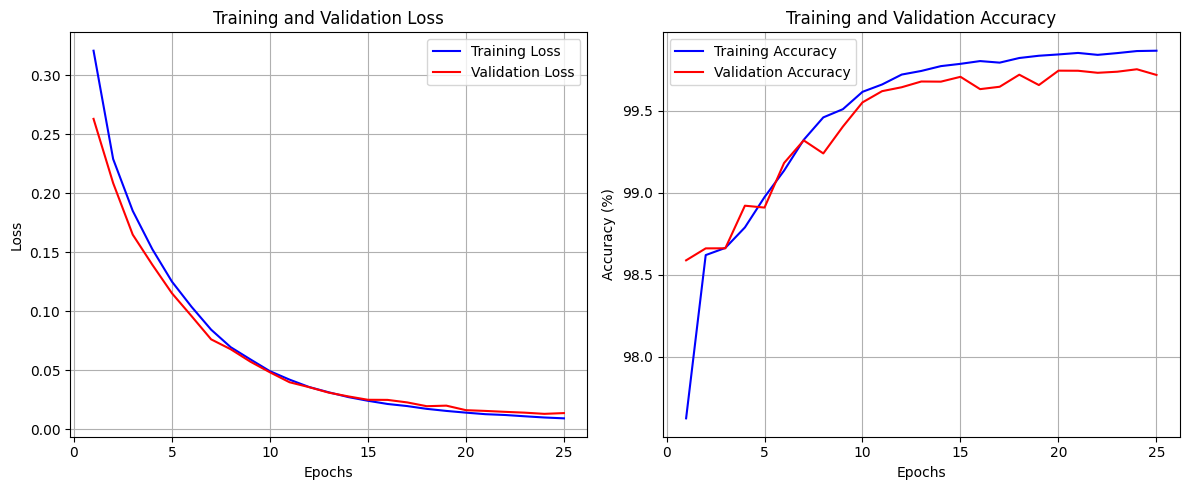


Final Training Accuracy: 99.87%
Final Validation Accuracy: 99.72%
Final Validation Loss: 0.0137


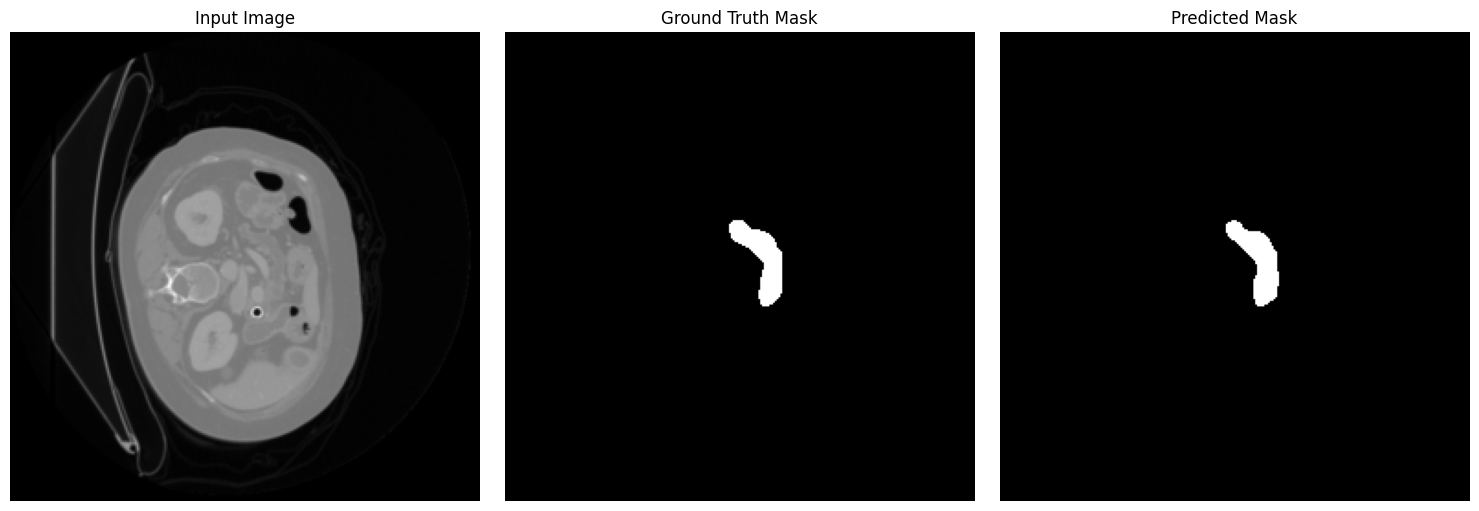

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torch.nn.functional as F

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the U-Net model
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        self.dconv_down1 = double_conv(n_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)

        self.conv_last = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Define the Dataset class
class CombinedPancreasDataset(Dataset):
    def __init__(self, t1_image_dir, t1_mask_dir, t2_image_dir, t2_mask_dir, transform=None):
        """
        A dataset class that combines healthy and tumorous pancreas images.
        """
        self.transform = transform
        
        # Get all images
        self.t1_image_paths = sorted([os.path.join(t1_image_dir, fname) for fname in os.listdir(t1_image_dir) if fname.endswith('.png')])
        self.t2_image_paths = sorted([os.path.join(t2_image_dir, fname) for fname in os.listdir(t2_image_dir) if fname.endswith('.png')])
        
        # Combine the lists
        self.image_paths = self.t1_image_paths + self.t2_image_paths
        
        # For each image path, find its corresponding mask path
        self.mask_paths = []
        self.valid_indices = [] 
        
        for idx, img_path in enumerate(self.image_paths):
            base_fname = os.path.basename(img_path)
            
            if 'cancer' in img_path:  
                corresponding_mask_path = os.path.join(t1_mask_dir, base_fname)
            else:  
                mask_fname = base_fname.replace('img_', 'mask_')
                corresponding_mask_path = os.path.join(t2_mask_dir, mask_fname)
            
            # Check if mask file actually exists
            if os.path.exists(corresponding_mask_path):
                self.mask_paths.append(corresponding_mask_path)
                self.valid_indices.append(idx)
            else:
                print(f"Warning: Mask file not found for image {base_fname}")
                print(f"  Expected mask at: {corresponding_mask_path}")
        
        
        self.image_paths = [self.image_paths[i] for i in self.valid_indices]
        
        print(f"Loaded {len(self.image_paths)} valid image-mask pairs")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Load image and mask
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        mask = Image.open(mask_path).convert('L')    
        
        # Apply transformations 
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        # Convert mask to binary (0 and 1) 
        mask = (mask > 0).float() 
        
        return image, mask
# transformations
input_size = (256, 256)
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
])

# Cancer pancreas paths (root directory)
t1_img_dir = '/kaggle/input/cancer/images'  
t1_msk_dir = '/kaggle/input/cancer/masks'   

# Normal pancreas paths (root directory)
t2_img_dir = '/kaggle/input/normal/images'  
t2_msk_dir = '/kaggle/input/normal/masks'   

# Create dataset
full_dataset = CombinedPancreasDataset(t1_img_dir, t1_msk_dir, t2_img_dir, t2_msk_dir, transform=transform)


# Split the dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# 3. Define model, loss, and optimizer
model = UNet(n_channels=1, n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary classification per pixel
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 4. Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# 5. Training loop
num_epochs = 25

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_correct_pixels = 0
    total_pixels = 0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item() * images.size(0)
        
        # Calculate training accuracy (for this batch)
        # Apply sigmoid to outputs and threshold at 0.5
        preds = torch.sigmoid(outputs) > 0.5
        running_correct_pixels += (preds == masks).float().sum().item()
        total_pixels += torch.numel(masks)
    
    # Calculate average training loss and accuracy 
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = (running_correct_pixels / total_pixels) * 100  
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    running_correct_pixels_val = 0
    total_pixels_val = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            
            # Calculate validation accuracy
            preds = torch.sigmoid(outputs) > 0.5
            running_correct_pixels_val += (preds == masks).float().sum().item()
            total_pixels_val += torch.numel(masks)
    
    # Calculate average validation loss and accuracy for this epoch
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = (running_correct_pixels_val / total_pixels_val) * 100  # Accuracy in %
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    # Print statistics every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    print('-' * 50)

print('Training Finished!')

print('Training Finished!')

# =============================================================================
# COMPREHENSIVE MODEL EVALUATION METRICS
# =============================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import seaborn as sns
from torchmetrics import JaccardIndex

def calculate_segmentation_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Flatten the predictions and masks for metric calculation
            all_preds.append(preds.cpu().view(-1))
            all_targets.append(masks.cpu().view(-1))
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Convert to numpy for sklearn metrics
    preds_np = all_preds.numpy()
    targets_np = all_targets.numpy()
    
    # Calculate metrics
    precision = precision_score(targets_np, preds_np, zero_division=0)
    recall = recall_score(targets_np, preds_np, zero_division=0)
    f1 = f1_score(targets_np, preds_np, zero_division=0)
    iou = jaccard_score(targets_np, preds_np, zero_division=0)
    
    return precision, recall, f1, iou, all_preds, all_targets

# Calculate metrics for both training and validation sets
print("Calculating comprehensive segmentation metrics...")

# Validation metrics
val_precision, val_recall, val_f1, val_iou, val_preds, val_targets = calculate_segmentation_metrics(model, val_loader, device)

# Training metrics 
train_precision, train_recall, train_f1, train_iou, train_preds, train_targets = calculate_segmentation_metrics(model, train_loader, device)

# Print all metrics
print("\n" + "="*60)
print("COMPREHENSIVE SEGMENTATION METRICS")
print("="*60)
print(f"{'Metric':<15} {'Training':<12} {'Validation':<12}")
print("-"*40)
print(f"{'Precision':<15} {train_precision:.4f}      {val_precision:.4f}")
print(f"{'Recall':<15} {train_recall:.4f}      {val_recall:.4f}")
print(f"{'F1-Score':<15} {train_f1:.4f}      {val_f1:.4f}")
print(f"{'IoU':<15} {train_iou:.4f}      {val_iou:.4f}")
print(f"{'Accuracy':<15} {train_accuracies[-1]:.2f}%     {val_accuracies[-1]:.2f}%")
print("="*60)

# =============================================================================
# CONFUSION MATRIX VISUALIZATION
# =============================================================================

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(preds, targets, title):
    cm = confusion_matrix(targets.numpy(), preds.numpy())
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Background', 'Pancreas'],
                yticklabels=['Background', 'Pancreas'])
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(val_preds, val_targets, "Validation Set")
plot_confusion_matrix(train_preds, train_targets, "Training Set")

# =============================================================================
# DETAILED CLASSIFICATION REPORT
# =============================================================================

from sklearn.metrics import classification_report

print("\nDETAILED CLASSIFICATION REPORT (Validation Set)")
print("="*50)
print(classification_report(val_targets.numpy(), val_preds.numpy(), 
                          target_names=['Background', 'Pancreas'],
                          digits=4))

# =============================================================================
# IoU (Jaccard Index) PER SAMPLE ANALYSIS
# =============================================================================

def calculate_iou_per_sample(model, dataloader, device):
    model.eval()
    ious = []
    
    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            # Calculate IoU for each sample in batch
            for i in range(preds.shape[0]):
                intersection = (preds[i] * masks[i]).sum()
                union = (preds[i] + masks[i]).sum() - intersection
                iou = (intersection / (union + 1e-6)).item()
                ious.append(iou)
    
    return ious

val_ious = calculate_iou_per_sample(model, val_loader, device)

print(f"\nIoU Statistics (Validation Set):")
print(f"  Mean IoU: {np.mean(val_ious):.4f}")
print(f"  Std IoU:  {np.std(val_ious):.4f}")
print(f"  Min IoU:  {np.min(val_ious):.4f}")
print(f"  Max IoU:  {np.max(val_ious):.4f}")

# Plot IoU distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(val_ious, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of IoU Scores (Validation)')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(val_ious)
plt.title('Box Plot of IoU Scores')
plt.ylabel('IoU Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('iou_distribution.png')
plt.show()

# =============================================================================
# SAVE ALL METRICS TO FILE
# =============================================================================

metrics_dict = {
    'train_accuracy': train_accuracies[-1],
    'val_accuracy': val_accuracies[-1],
    'train_precision': train_precision,
    'val_precision': val_precision,
    'train_recall': train_recall,
    'val_recall': val_recall,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'train_iou': train_iou,
    'val_iou': val_iou,
    'val_iou_mean': np.mean(val_ious),
    'val_iou_std': np.std(val_ious)
}

# Save metrics to text file
with open('segmentation_metrics.txt', 'w') as f:
    f.write("PANCREAS SEGMENTATION METRICS REPORT\n")
    f.write("="*50 + "\n")
    for key, value in metrics_dict.items():
        f.write(f"{key}: {value:.4f}\n")

print("\nAll metrics calculated and saved successfully!")
print("Files created:")
print("- confusion_matrix_validation_set.png")
print("- confusion_matrix_training_set.png") 
print("- iou_distribution.png")
print("- segmentation_metrics.txt")


# Save the trained model
torch.save(model.state_dict(), 'unet_pancreas_segmentation.pth')
print("Model saved!")

# Plot the Loss and Accuracy graphs
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')  
plt.show()

# Print final metrics
print(f'\nFinal Training Accuracy: {train_accuracies[-1]:.2f}%')
print(f'Final Validation Accuracy: {val_accuracies[-1]:.2f}%')
print(f'Final Validation Loss: {val_losses[-1]:.4f}')

# Test the model on a sample from validation set
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_images, sample_masks = next(iter(val_loader))
    sample_images, sample_masks = sample_images.to(device), sample_masks.to(device)
    
    # Predict
    sample_outputs = model(sample_images)
    sample_preds = torch.sigmoid(sample_outputs) > 0.5
    
    # Visualize the first sample in the batch
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Input image
    axes[0].imshow(sample_images[0].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    # Ground truth mask
    axes[1].imshow(sample_masks[0].cpu().squeeze(), cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')
    
    # Predicted mask
    axes[2].imshow(sample_preds[0].cpu().squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_prediction.png')
    plt.show()

In [4]:
import torch
import numpy as np
from PIL import Image
import os
from torchvision import transforms

# Load trained segmentation model
model = UNet(n_channels=1, n_classes=1).to(device)
model.load_state_dict(torch.load('unet_pancreas_segmentation.pth'))
model.eval()
print("Segmentation model loaded successfully!")

def extract_pancreas_regions(image_paths, mask_paths, output_dir, original_size=(512, 512)):
    """
    Extract pancreas regions from images using ground truth masks
    """
    os.makedirs(output_dir, exist_ok=True)
    
    for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        try:
            # Load original image and mask
            image = Image.open(img_path).convert('L')
            mask = Image.open(mask_path).convert('L')
            
            # Resize to original
            image = image.resize(original_size, Image.BILINEAR)
            mask = mask.resize(original_size, Image.NEAREST)
            
            # Convert to numpy arrays
            image_np = np.array(image)
            mask_np = np.array(mask) > 0  
            
            # Extract pancreas region
            pancreas_region = image_np * mask_np
            
            # Find bounding box of pancreas to crop tightly
            coords = np.argwhere(mask_np > 0)
            if len(coords) > 0:
                y_min, x_min = coords.min(axis=0)
                y_max, x_max = coords.max(axis=0)
                
                # Add some padding
                padding = 10
                x_min = max(0, x_min - padding)
                y_min = max(0, y_min - padding)
                x_max = min(image_np.shape[1], x_max + padding)
                y_max = min(image_np.shape[0], y_max + padding)
                
                # Crop the region
                cropped_region = pancreas_region[y_min:y_max, x_min:x_max]
                
                # Save the extracted pancreas image
                if cropped_region.size > 0:  
                    output_path = os.path.join(output_dir, f'pancreas_{i:04d}.png')
                    Image.fromarray(cropped_region).save(output_path)
                    
            if (i + 1) % 50 == 0:
                print(f"Processed {i+1} images...")
                
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

# Get all image paths 
t1_image_paths = sorted([os.path.join(t1_img_dir, f) for f in os.listdir(t1_img_dir) if f.endswith('.png')])
t1_mask_paths = []
t2_image_paths = sorted([os.path.join(t2_img_dir, f) for f in os.listdir(t2_img_dir) if f.endswith('.png')])
t2_mask_paths = []

for img_path in t1_image_paths:
    base_fname = os.path.basename(img_path)
    mask_path = os.path.join(t1_msk_dir, base_fname)  
    if os.path.exists(mask_path):
        t1_mask_paths.append(mask_path)

for img_path in t2_image_paths:
    base_fname = os.path.basename(img_path)
    mask_fname = base_fname.replace('img_', 'mask_')  
    mask_path = os.path.join(t2_msk_dir, mask_fname)
    if os.path.exists(mask_path):
        t2_mask_paths.append(mask_path)


t1_image_paths.sort()
t1_mask_paths.sort()
t2_image_paths.sort()
t2_mask_paths.sort()

print(f"Found {len(t1_image_paths)} cancer images and {len(t1_mask_paths)} cancer masks")
print(f"Found {len(t2_image_paths)} normal images and {len(t2_mask_paths)} normal masks")


# Create classification dataset
print("Creating NON-cancerous dataset from NORMAL images...")
extract_pancreas_regions(t2_image_paths, t2_mask_paths,  
                        '/kaggle/working/classification_dataset/non_cancerous')

print("Creating CANCEROUS dataset from CANCER images...")
extract_pancreas_regions(t1_image_paths, t1_mask_paths,  
                        '/kaggle/working/classification_dataset/cancerous')

print("Dataset creation completed!")
print("Contents of classification dataset:")
classification_base = '/kaggle/working/classification_dataset'
non_cancerous_count = len(os.listdir(os.path.join(classification_base, 'non_cancerous')))
cancerous_count = len(os.listdir(os.path.join(classification_base, 'cancerous')))

print(f"Non-cancerous images: {non_cancerous_count}")
print(f"Cancerous images: {cancerous_count}")

Segmentation model loaded successfully!
Found 516 cancer images and 516 cancer masks
Found 712 normal images and 712 normal masks
Creating NON-cancerous dataset from NORMAL images...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Processed 550 images...
Processed 600 images...
Processed 650 images...
Processed 700 images...
Creating CANCEROUS dataset from CANCER images...
Processed 50 images...
Processed 100 images...
Processed 150 images...
Processed 200 images...
Processed 250 images...
Processed 300 images...
Processed 350 images...
Processed 400 images...
Processed 450 images...
Processed 500 images...
Dataset creation completed!
Contents of classification dataset:
Non-cancerous images: 712
Cancerous images: 516


Using device: cuda
Training images: 982
Validation images: 246
Classes: ['cancerous', 'non_cancerous']


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Starting training...
Epoch [1/15]
  Train Loss: 0.0797, Train Acc: 95.82%
  Val Loss: 0.0375, Val Acc: 98.78%
--------------------------------------------------
Epoch [2/15]
  Train Loss: 0.0137, Train Acc: 99.59%
  Val Loss: 0.0026, Val Acc: 100.00%
--------------------------------------------------
Epoch [3/15]
  Train Loss: 0.0059, Train Acc: 99.80%
  Val Loss: 0.3224, Val Acc: 93.90%
--------------------------------------------------
Epoch [4/15]
  Train Loss: 0.0194, Train Acc: 99.29%
  Val Loss: 0.0037, Val Acc: 100.00%
--------------------------------------------------
Epoch [5/15]
  Train Loss: 0.0013, Train Acc: 100.00%
  Val Loss: 0.0003, Val Acc: 100.00%
--------------------------------------------------
Epoch [6/15]
  Train Loss: 0.0013, Train Acc: 100.00%
  Val Loss: 0.0001, Val Acc: 100.00%
--------------------------------------------------
Epoch [7/15]
  Train Loss: 0.0004, Train Acc: 100.00%
  Val Loss: 0.0001, Val Acc: 100.00%
------------------------------------------

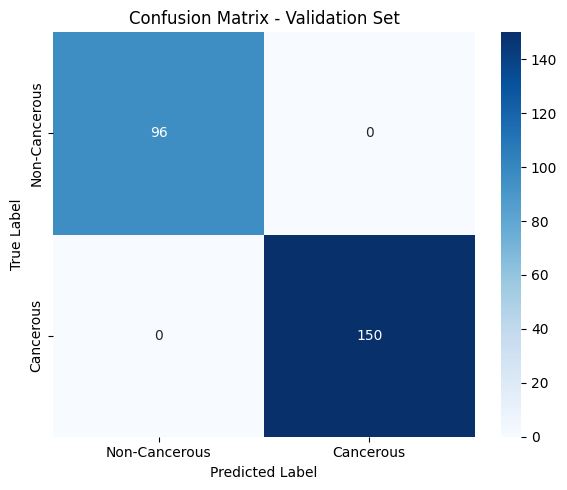

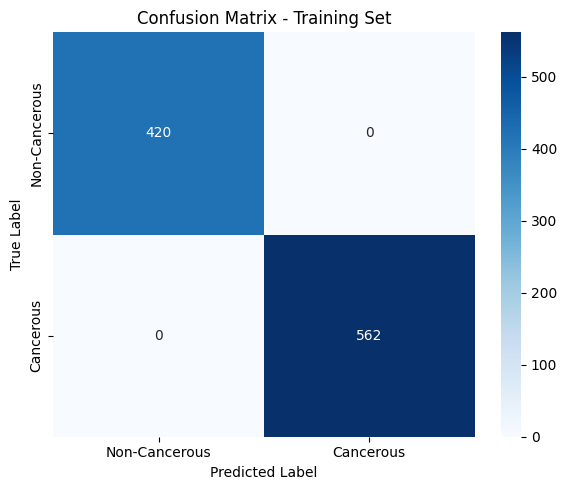


DETAILED CLASSIFICATION REPORT (Validation Set)
               precision    recall  f1-score   support

Non-Cancerous     1.0000    1.0000    1.0000        96
    Cancerous     1.0000    1.0000    1.0000       150

     accuracy                         1.0000       246
    macro avg     1.0000    1.0000    1.0000       246
 weighted avg     1.0000    1.0000    1.0000       246


Additional Metrics:
Validation Specificity (True Negative Rate): 1.0000
Training Specificity (True Negative Rate): 1.0000

All classification metrics calculated and saved successfully!


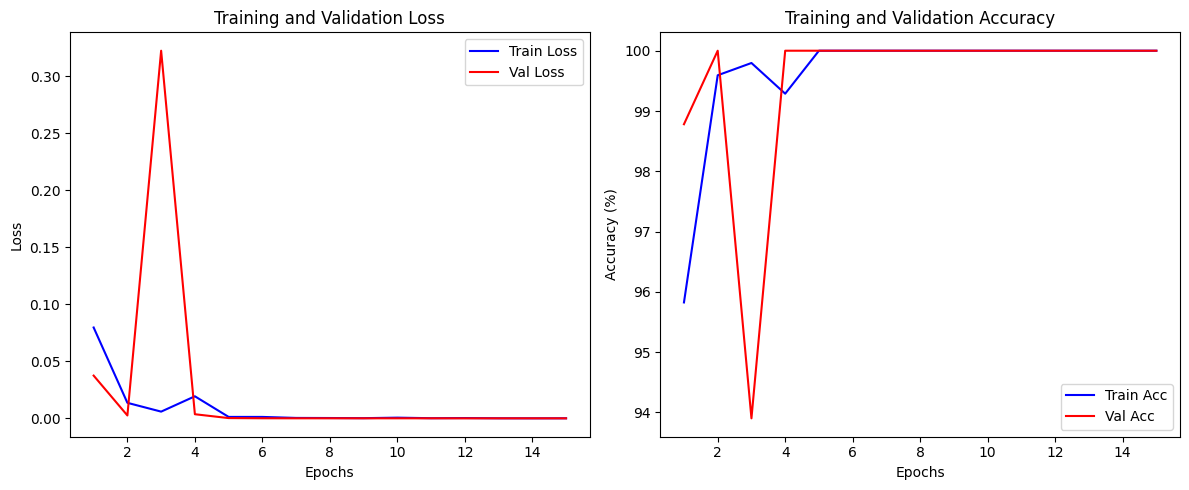


Final Validation Accuracy: 100.00%
Final Validation Loss: 0.0001


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/kaggle/working/classification_dataset'
dataset = datasets.ImageFolder(data_dir, transform=train_transform)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Update validation dataset transforms
val_dataset.dataset.transform = val_transform

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")
print(f"Classes: {dataset.classes}")

# Load pretrained ResNet model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training setup
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = 100 * correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
    print(f'  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
    print('-' * 50)

# Save the trained model
torch.save(model.state_dict(), 'cancer_classifier.pth')
print("Cancer classifier model saved!")


# =============================================================================
# COMPREHENSIVE CLASSIFICATION EVALUATION
# =============================================================================

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

def evaluate_classification(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

print("Calculating comprehensive classification metrics...")

# Get predictions for both sets
y_true_val, y_pred_val = evaluate_classification(model, val_loader, device)
y_true_train, y_pred_train = evaluate_classification(model, train_loader, device)

# Calculate metrics
val_precision = precision_score(y_true_val, y_pred_val, average='binary')
val_recall = recall_score(y_true_val, y_pred_val, average='binary')
val_f1 = f1_score(y_true_val, y_pred_val, average='binary')

train_precision = precision_score(y_true_train, y_pred_train, average='binary')
train_recall = recall_score(y_true_train, y_pred_train, average='binary')
train_f1 = f1_score(y_true_train, y_pred_train, average='binary')

# Print all metrics
print("\n" + "="*60)
print("COMPREHENSIVE CLASSIFICATION METRICS")
print("="*60)
print(f"{'Metric':<15} {'Training':<12} {'Validation':<12}")
print("-"*40)
print(f"{'Accuracy':<15} {train_accuracies[-1]:.2f}%     {val_accuracies[-1]:.2f}%")
print(f"{'Precision':<15} {train_precision:.4f}      {val_precision:.4f}")
print(f"{'Recall':<15} {train_recall:.4f}      {val_recall:.4f}")
print(f"{'F1-Score':<15} {train_f1:.4f}      {val_f1:.4f}")
print("="*60)

# =============================================================================
# CONFUSION MATRIX VISUALIZATION
# =============================================================================

def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()
    
    return cm

# Plot confusion matrices
class_names = ['Non-Cancerous', 'Cancerous']
val_cm = plot_confusion_matrix(y_true_val, y_pred_val, "Validation Set", class_names)
train_cm = plot_confusion_matrix(y_true_train, y_pred_train, "Training Set", class_names)

# =============================================================================
# DETAILED CLASSIFICATION REPORT
# =============================================================================

print("\nDETAILED CLASSIFICATION REPORT (Validation Set)")
print("="*50)
print(classification_report(y_true_val, y_pred_val, 
                          target_names=class_names, digits=4))

# =============================================================================
# ADDITIONAL METRICS CALCULATION
# =============================================================================

# Calculate specificity (True Negative Rate)
def calculate_specificity(cm):
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return specificity

val_specificity = calculate_specificity(val_cm)
train_specificity = calculate_specificity(train_cm)

print(f"\nAdditional Metrics:")
print(f"Validation Specificity (True Negative Rate): {val_specificity:.4f}")
print(f"Training Specificity (True Negative Rate): {train_specificity:.4f}")

# =============================================================================
# SAVE ALL METRICS TO FILE
# =============================================================================

metrics_dict = {
    'train_accuracy': train_accuracies[-1],
    'val_accuracy': val_accuracies[-1],
    'train_precision': train_precision,
    'val_precision': val_precision,
    'train_recall': train_recall,
    'val_recall': val_recall,
    'train_f1': train_f1,
    'val_f1': val_f1,
    'val_specificity': val_specificity,
    'train_specificity': train_specificity
}

# Save metrics to text file
with open('classification_metrics.txt', 'w') as f:
    f.write("CANCER CLASSIFICATION METRICS REPORT\n")
    f.write("="*50 + "\n")
    f.write(f"Classes: {class_names}\n")
    f.write(f"0: {class_names[0]}, 1: {class_names[1]}\n\n")
    for key, value in metrics_dict.items():
        f.write(f"{key}: {value:.4f}\n")
    
    f.write("\nConfusion Matrix (Validation):\n")
    f.write(str(val_cm))

print("\nAll classification metrics calculated and saved successfully!")

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, 'b-', label='Train Acc')
plt.plot(range(1, num_epochs+1), val_accuracies, 'r-', label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('cancer_classifier_metrics.png')
plt.show()

print(f'\nFinal Validation Accuracy: {val_accuracies[-1]:.2f}%') 
print(f'Final Validation Loss: {val_losses[-1]:.4f}')


TEST CASE 1: NON-CANCEROUS
File: img_04581.png
Debug - Class 0 (cancerous): 0.0011
Debug - Class 1 (non_cancerous): 0.9989
Diagnosis: NON-CANCEROUS
Cancer Probability: 0.11%
Confidence: 99.89%


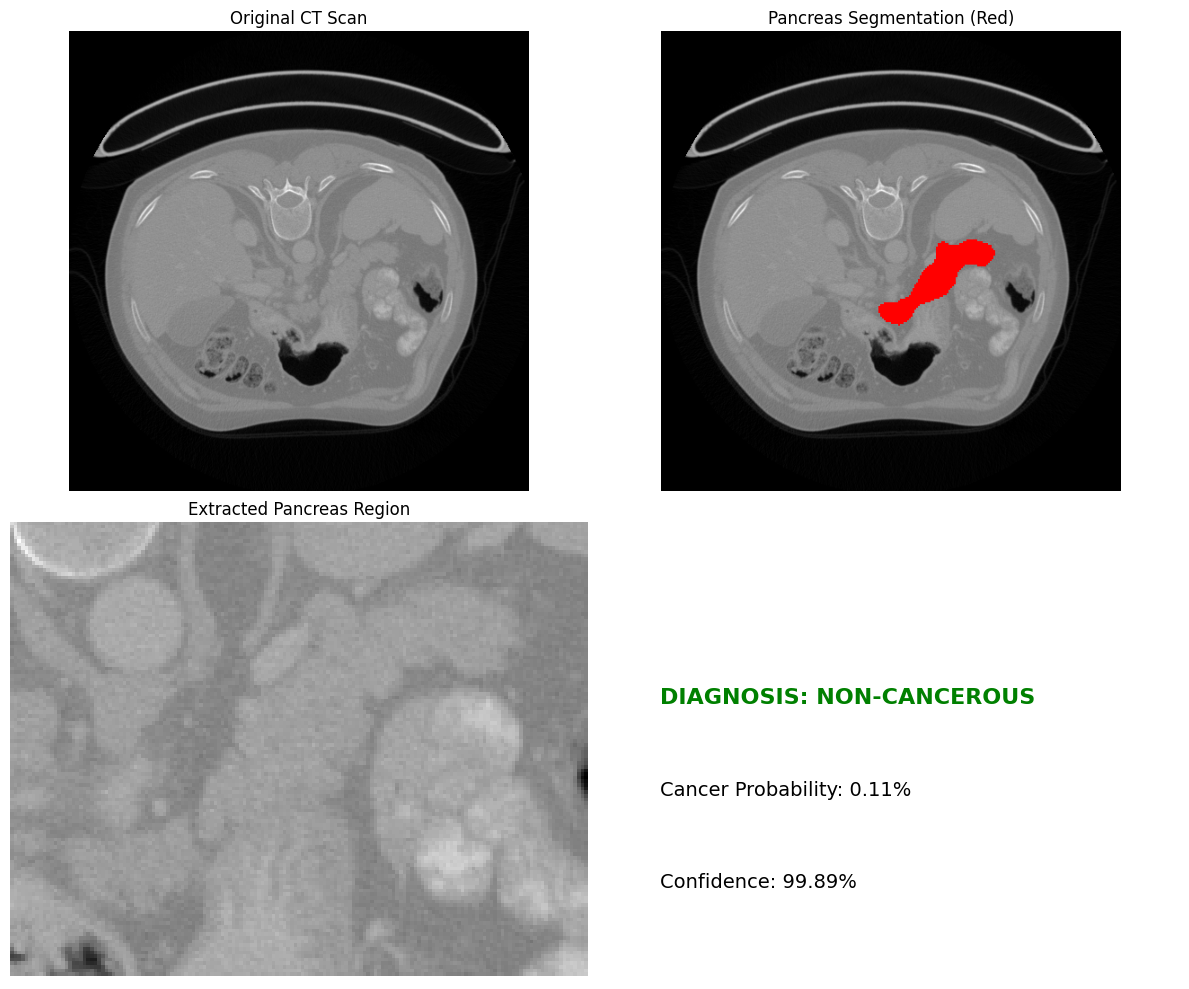


TEST CASE 2: CANCEROUS
File: pancreas_012_slice_051.png
Debug - Class 0 (cancerous): 0.7338
Debug - Class 1 (non_cancerous): 0.2662
Diagnosis: CANCEROUS
Cancer Probability: 73.38%
Confidence: 73.38%


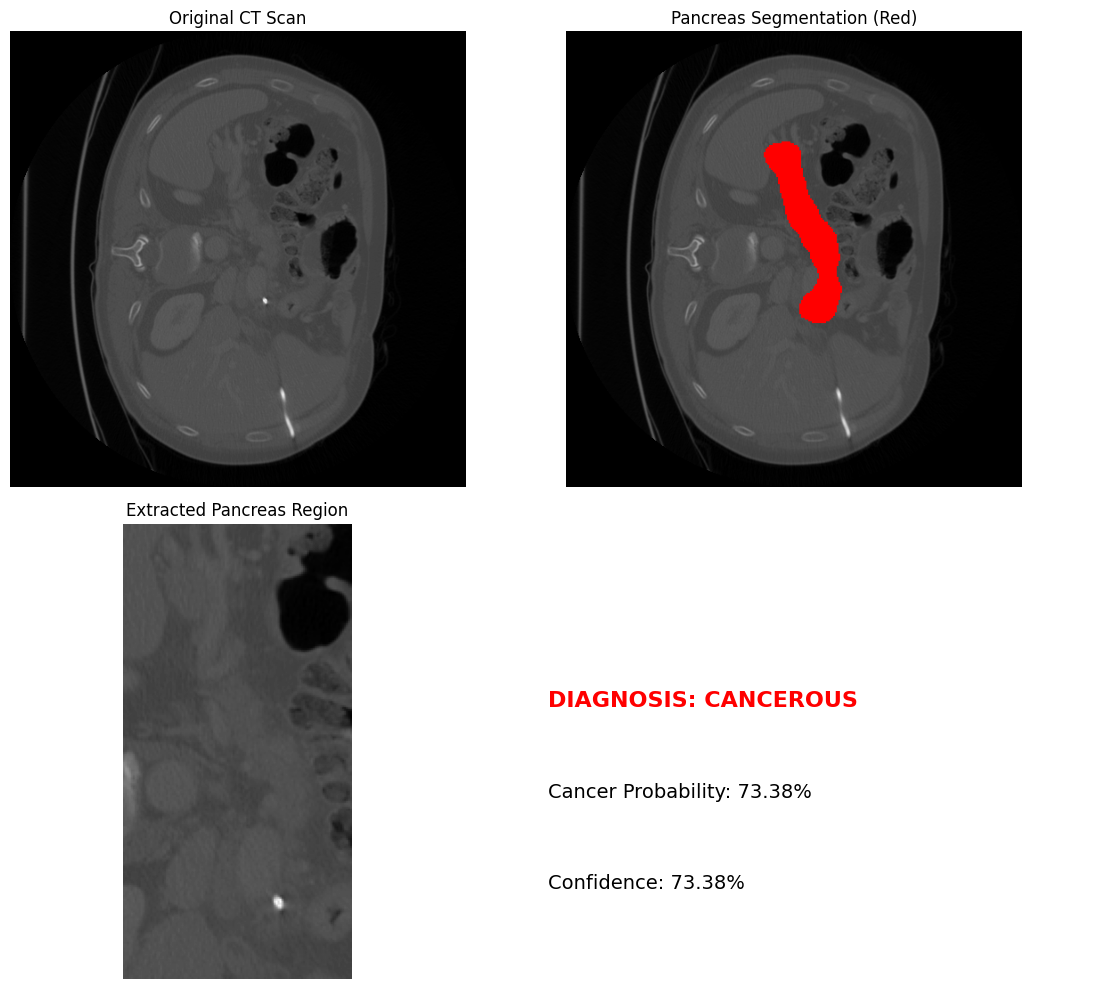

In [20]:
def predict_cancer_from_scan(scan_path, unet_model, cancer_classifier, device):
    """
    Complete pipeline: Segment -> Extract -> Classify -> Visualize
    Returns both diagnosis and visual outputs
    """
    # Transform for input image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    # 1. Load and preprocess the new CT scan
    original_image = Image.open(scan_path).convert('L')
    original_np = np.array(original_image)
    original_size = original_image.size  
    
    image_tensor = transform(original_image).unsqueeze(0).to(device)
    
    # 2. Segment pancreas 
    unet_model.eval()
    with torch.no_grad():
        segmentation_output = unet_model(image_tensor)
        pancreas_mask = torch.sigmoid(segmentation_output) > 0.5
    
    #  Extract pancreas region from original image 
    # Convert mask to numpy and resize to original image size
    mask_np = pancreas_mask.squeeze().cpu().numpy().astype(np.uint8)
    
    # Resize mask to match original image dimensions
    from PIL import Image as PILImage
    mask_pil = PILImage.fromarray(mask_np * 255)  
    mask_resized = mask_pil.resize(original_size, PILImage.NEAREST)  
    mask_np_resized = np.array(mask_resized) > 0  
    
    # Create overlay: red mask on original image
    overlay = np.stack([original_np] * 3, axis=-1)  
    overlay[mask_np_resized > 0] = [255, 0, 0]  
    
    # Extract just the pancreas region
    coords = np.argwhere(mask_np_resized > 0)
    if len(coords) > 0:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        padding = 15
        x_min = max(0, x_min - padding)
        y_min = max(0, y_min - padding)
        x_max = min(original_np.shape[1], x_max + padding)
        y_max = min(original_np.shape[0], y_max + padding)
        cropped_pancreas = original_np[y_min:y_max, x_min:x_max]
    else:
        cropped_pancreas = np.zeros((50, 50))  
    
    # 4. Prepare pancreas region for classification
    pancreas_tensor = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ])(PILImage.fromarray(cropped_pancreas)).unsqueeze(0).to(device)
    
    
    # Classification
    cancer_classifier.eval()
    with torch.no_grad():
        classification_output = cancer_classifier(pancreas_tensor)
        prediction = torch.softmax(classification_output, dim=1)
    
    
    cancer_probability = prediction[0][0].item()  
    non_cancer_probability = prediction[0][1].item()  
    
   
    print(f"Debug - Class 0 (cancerous): {cancer_probability:.4f}")
    print(f"Debug - Class 1 (non_cancerous): {non_cancer_probability:.4f}")
    return {
        'diagnosis': 'CANCEROUS' if cancer_probability > 0.5 else 'NON-CANCEROUS',
        'cancer_probability': cancer_probability,  # This is now correct
        'non_cancer_probability': non_cancer_probability,
        'original_scan': original_np,
        'segmentation_mask': mask_np_resized,
        'overlay_image': overlay,
        'pancreas_region': cropped_pancreas,
        'confidence': max(cancer_probability, non_cancer_probability)
}

def visualize_diagnosis(results):
    """
    Create a comprehensive visualization of the results
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original scan
    axes[0, 0].imshow(results['original_scan'], cmap='gray')
    axes[0, 0].set_title('Original CT Scan')
    axes[0, 0].axis('off')
    
    # Segmentation overlay
    axes[0, 1].imshow(results['overlay_image'])
    axes[0, 1].set_title('Pancreas Segmentation (Red)')
    axes[0, 1].axis('off')
    
    # Extracted pancreas region
    axes[1, 0].imshow(results['pancreas_region'], cmap='gray')
    axes[1, 0].set_title('Extracted Pancreas Region')
    axes[1, 0].axis('off')
    
    # Diagnosis and probability
    axes[1, 1].text(0.1, 0.6, f"DIAGNOSIS: {results['diagnosis']}", 
                   fontsize=16, weight='bold', 
                   color='red' if results['diagnosis'] == 'CANCEROUS' else 'green')
    axes[1, 1].text(0.1, 0.4, f"Cancer Probability: {results['cancer_probability']:.2%}", 
                   fontsize=14)
    axes[1, 1].text(0.1, 0.2, f"Confidence: {results['confidence']:.2%}", 
                   fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('patient_diagnosis_report.png', dpi=300, bbox_inches='tight')
    plt.show()

# Load trained models
unet_model = UNet(n_channels=1, n_classes=1).to(device)
unet_model.load_state_dict(torch.load('unet_pancreas_segmentation.pth'))

# For cancer classifier
cancer_classifier = models.resnet18(pretrained=False)
cancer_classifier.fc = nn.Linear(cancer_classifier.fc.in_features, 2)
cancer_classifier.load_state_dict(torch.load('cancer_classifier.pth'))
cancer_classifier = cancer_classifier.to(device)

# Test
test_cases = [
    '/kaggle/input/normal/images/img_04581.png',  # Non-cancerous
    '/kaggle/input/cancer/images/pancreas_012_slice_051.png'   # Cancerous
]

for i, scan_path in enumerate(test_cases):
    if os.path.exists(scan_path):
        print(f"\n{'='*50}")
        
        case_type = 'NON-CANCEROUS' if 'normal' in scan_path else 'CANCEROUS'
        print(f"TEST CASE {i+1}: {case_type}")
        print(f"File: {os.path.basename(scan_path)}")
        print('='*50)
        
        results = predict_cancer_from_scan(scan_path, unet_model, cancer_classifier, device)
        print(f"Diagnosis: {results['diagnosis']}")
        print(f"Cancer Probability: {results['cancer_probability']:.2%}")
        print(f"Confidence: {results['confidence']:.2%}")
        visualize_diagnosis(results)
    else:
        print(f"File not found: {scan_path}")
        # alternative test file
        print("Looking for available test files...")
        
        
        normal_files = os.listdir('/kaggle/input/normal/images') if os.path.exists('/kaggle/input/normal/images') else []
        cancer_files = os.listdir('/kaggle/input/cancer/images') if os.path.exists('/kaggle/input/cancer/images') else []
        
        if normal_files:
            alt_normal = os.path.join('/kaggle/input/normal/images', normal_files[0])
            print(f"Try instead: {alt_normal}")
        if cancer_files:
            alt_cancer = os.path.join('/kaggle/input/cancer/images', cancer_files[0])
            print(f"Try instead: {alt_cancer}")
        